In [6]:
from importlib import reload
import perplexity
import lda_neuron_selection
import neuron_selection
reload(neuron_selection)
reload(lda_neuron_selection)
reload(perplexity)
from perplexity import PerplexityAnalyzer
from transformers import GPT2Tokenizer
from gpt2 import GPT2LMHeadModel
import pandas as pd
from neuron_selection import NeuronSelector
from lda_neuron_selection import LdaNeuronSelector
import numpy as np
import torch

from matplotlib import pyplot as plt, rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats

rcParams["figure.figsize"] = (8, 5)
rcParams["figure.dpi"] = 100
set_matplotlib_formats("retina")
plt.style.use("seaborn")

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.eval()

perplexity_df = pd.read_csv("data/wiki.csv")

In [7]:
neuron_selector = NeuronSelector()
neurons_per_layer = neuron_selector.get_neurons_per_layer(n_neurons=100, percentile=0.8, method="pca_correlation")

In [8]:
neuron_selector = LdaNeuronSelector(filename="output/output.npz")
neurons_per_layer = neuron_selector.get_lda_neurons_per_layer(n_layers=25, percentile=0.8, method="correlation")

AttributeError: 'LdaNeuronSelector' object has no attribute 'get_neurons_per_layer'

In [8]:
perp_analyzer = PerplexityAnalyzer(model, tokenizer, df=perplexity_df.sample(10))

In [10]:
perp_analyzer.get_average_perplexity(neurons_per_layer=neurons_per_layer, force_emotion="negative", force_with="transform")

KeyError: 'dicts'

In [67]:
BATCH_SIZE = 5
n_batches = len(perplexity_df) // BATCH_SIZE + 1
batch = next(iter(np.array_split(perplexity_df, n_batches)))
sentences = batch["sentence"].values.tolist()
sentences

["It tells the story of the making of Bandolier in the band's own words, including an extensive audio interview with Burke Shelley.",
 'Under his conditions it produces pitchers that are almost completley black.',
 "Given that they're pulling out all the stops, they deserve all the acclaim that surrounded them for their first two albums.",
 'It was their second EP and, like their first EP, was released only in Australia.',
 'Contains a detailed monograph on Schisandra chinensis as well as highlights health benefits.']

In [69]:
tokenizer.pad_token = tokenizer.eos_token
input = tokenizer(sentences, padding=True, return_tensors="pt")

In [70]:
input['input_ids'].shape

torch.Size([5, 27])

In [71]:
with torch.no_grad():
    output = model(
        **input,
        neurons_per_layer=neurons_per_layer,
        force_emotion="negative",
        force_with="per_neuron",
    )

In [73]:
log_probs = torch.nn.functional.log_softmax(output.logits, dim=2)
# likelihood_sequence = self.get_likelihood_sequence(input, log_probs)

In [79]:
[
    log_probs[:, i, token_index].item()
    for i, token_index in enumerate(input.input_ids[:, 1:])
]

ValueError: only one element tensors can be converted to Python scalars

In [89]:
token_ids = next(iter(input.input_ids[:, 1:].T))
np.diag(log_probs[:, 0, token_ids])

array([-7.7975893, -5.226864 , -1.6991314, -2.449772 , -4.5495253],
      dtype=float32)

In [88]:
token_ids

tensor([4952,  465,  326,  373, 1299])

In [98]:
results = [
    {'a': 1, 'b': 2},
    {'a': 3, 'b': 4},
]

pd.DataFrame(results)

,a,b
0,1,2
1,3,4


In [112]:
lda_neuron_selector = LdaNeuronSelector(filename="output/output.npz")

In [120]:
neurons_per_layer = lda_neuron_selector.get_lda_neurons_per_layer(
    n_layers=25,
    percentile=0.8,
    method="logistic_regression",
)

In [137]:
# hyperparams = [
#     {
#         "selection_method": [
#             "correlation",
#         ],
#         "n_neurons": [100, 200, 500, 1000, 5000],
#         "percentile": [0.5, 0.8, 1],
#     },
#     {
#         "selection_method": [
#             "logistic_regression",
#         ],
#         "n_neurons": [100, 200, 500, 1000, 5000],
#         "percentile": [0.5, 0.8, 1],
#     },
#     {
#         "selection_method": [
#             "pca_correlation",
#         ],
#         "n_neurons": [100, 200, 500, 1000, 5000],
#         "percentile": [0.5, 0.8, 1],
#     },
#     {
#         "selection_method": [
#             "pca_log_reg",
#         ],
#         "n_neurons": [100, 200, 500, 1000, 5000],
#         "percentile": [0.5, 0.8, 1],
#     },
# ]

hyperparams = {
    "selection_method": [
        "correlation",
        "logistic_regression",
        "pca_correlation",
        "pca_log_reg",
    ],
    "n_neurons": [100],
    "percentile": [1],
}


In [138]:
# Import parameter grid
from sklearn.model_selection import ParameterGrid

list(ParameterGrid(hyperparams))

[{'n_neurons': 100, 'percentile': 1, 'selection_method': 'correlation'},
 {'n_neurons': 100,
  'percentile': 1,
  'selection_method': 'logistic_regression'},
 {'n_neurons': 100, 'percentile': 1, 'selection_method': 'pca_correlation'},
 {'n_neurons': 100, 'percentile': 1, 'selection_method': 'pca_log_reg'}]

In [145]:
df = pd.read_csv('output/hyperparam/results.csv')
lda_df = pd.read_csv('output/hyperparam/lda_results.csv')

In [156]:
lda_df

,layer_selection_method,n_layers,percentile,selection_method,n_negative,average_perplexity,output_filename
0,correlation,1,0.5,lda,308,80.771672,output/hyperparam/dfs/lda_correlation_1_50.csv
1,correlation,1,0.8,lda,319,80.782465,output/hyperparam/dfs/lda_correlation_1_80.csv
2,correlation,1,1.0,lda,339,80.820993,output/hyperparam/dfs/lda_correlation_1_100.csv
3,correlation,10,0.5,lda,326,81.949816,output/hyperparam/dfs/lda_correlation_10_50.csv
4,correlation,10,0.8,lda,337,81.976154,output/hyperparam/dfs/lda_correlation_10_80.csv
5,correlation,10,1.0,lda,345,82.087765,output/hyperparam/dfs/lda_correlation_10_100.csv
6,correlation,25,0.5,lda,314,81.991766,output/hyperparam/dfs/lda_correlation_25_50.csv
7,correlation,25,0.8,lda,359,82.047800,output/hyperparam/dfs/lda_correlation_25_80.csv
8,correlation,25,1.0,lda,375,82.327919,output/hyperparam/dfs/lda_correlation_25_100.csv
9,correlation,49,0.5,lda,320,83.820453,output/hyperparam/dfs/lda_correlation_49_50.csv


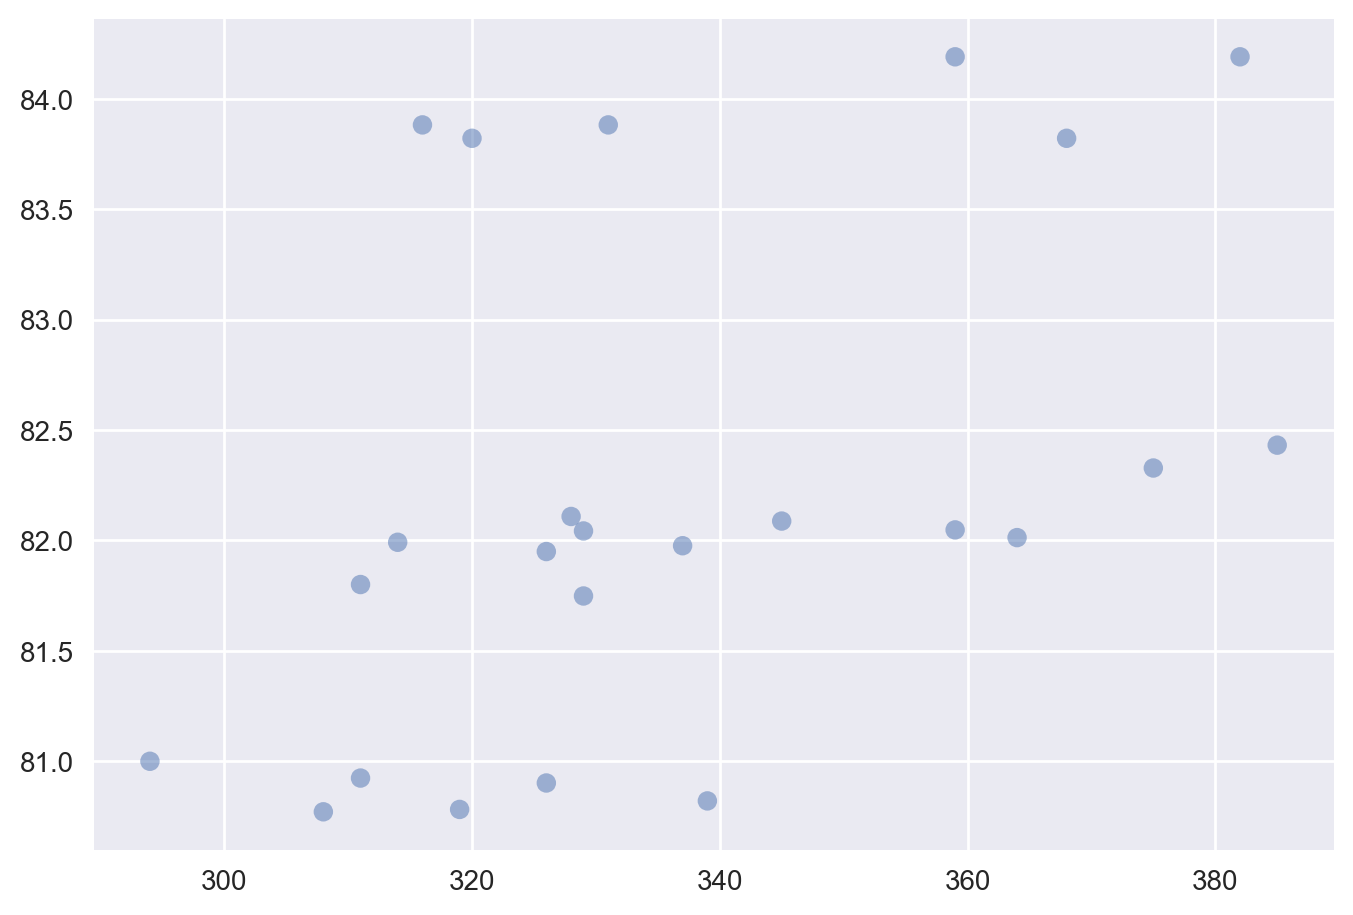

In [155]:
# plt.scatter(df['n_negative'], df['average_perplexity'], alpha=0.5, edgecolors='none')
plt.scatter(lda_df['n_negative'], lda_df['average_perplexity'], alpha=0.5, edgecolors='none')
# Make the x axis logarithmic
# plt.yscale('log')
plt.show()